# Butler Query & Source Injection Tutorial Notebook
(Notebook for Daniel) <br>
For the Rubin Science Platform at <a href="https://data.lsst.cloud">data.lsst.cloud</a><br>
Data Release: <a href="https://dp1.lsst.io/">Data Preview 1 (DP1)</a> <br>

**Learning Objective:** To learn how to query DP1 for different image types using Butler and inject sources into those images

**LSST Data Products:** `visit_image`, `deep_coadd`

**Packages:** `lsst.daf.butler`, `lsst.rsp`, `lsst.afw.display`, `lsst.source.injection`

**Credit:** This notebook was created by Dhruv Sharma using code developed by Shenming Fu (SLAC National Accelerator Laboratory)

Also see: DP0.2 Tutorial Notebook: https://github.com/lsst/tutorial-notebooks/blob/main/DP0.2/14_Injecting_Synthetic_Sources.ipynb

## 1. Introduction

The Butler is LSST Science Pipeline's interface between pipelines and data for managing, reading, and writing datasets. Documentation and help for Butler can be found at:
* [pipelines middleware Frequently Asked Questions](https://pipelines.lsst.io/middleware/index.html)
* [Butler python module documentation](https://pipelines.lsst.io/modules/lsst.daf.butler/index.html)
* [Butler query expressions and operators](https://pipelines.lsst.io/modules/lsst.daf.butler/queries.html#datasettype-expressions)

**This notebook** uses several python programs written by Shenming Fu to supplement Butler and the LSST Science Pipeline and facilitate our queries/injections.

**Related notebooks** may be found in the 100-level Butler tutorials provided by the Rubin Science Platform that further detail how to explore, discover, and manipulate Rubin datasets. 

### 1.1. Import packages

Start by importing the various files in `lib` to access their helpful supplementary methods. We will also use the `butler` and `timespan` modules of the `lsst.daf` package, as well as `lsst.afw`'s `display` module to view our images.

In [1]:
from lsst.daf.butler import Butler, Timespan
import matplotlib.pyplot as plt
from astropy.table import Table, vstack
%matplotlib inline
import lsst.afw.display as afwDisplay
from lsst.source.injection import generate_injection_catalog
from lsst.source.injection import VisitInjectConfig, VisitInjectTask
from lsst.source.injection import CoaddInjectConfig, CoaddInjectTask
from lib.visual import *

### 1.2. Using the Butler to retrieve visit images

Create a new instance of the Butler configured to query DP1 data from the LSSTComCam.

In [2]:
BUTLER_CONFIG = "dp1"
COLLECTIONS = "LSSTComCam/DP1"
butler = Butler(BUTLER_CONFIG, collections=COLLECTIONS) 
afwDisplay.setDefaultBackend('matplotlib')
%matplotlib inline

Use the Butler's `query_datasets` method to find `visit_image`s corresponding to the  band and ra,dec (right-ascension, declination) coordinates given in the "bind" of the formatted string, in this case:
>ra = 37.86, dec = 6.98 <br>
>band = 'r'

There can and often may be be multiple visit images covering the same ra,dec position, as seen by printing the length of `visit_data`.

In [3]:
ra=37.93
dec=6.93
band = 'r'
query = "band.name = :band AND \
    visit_detector_region.region OVERLAPS POINT(:ra, :dec)"
bind = {"band": band, "ra": ra, "dec": dec}
visit_data = butler.query_datasets("visit_image",
                                     where=query,
                                     order_by=["visit.timespan.begin"],
                                     bind=bind)

print(len(visit_data))

9


As a bit of foresight for the sake of this tutorial, we wish to inject sources into both a `visit_image` and a `deep_coadd` image, which may not necessarily have a frame that matches that of the `visit_image` closely. So, let's choose an index of `visit_data` to query that has a visit_image with a convenient framing to allow us to inject into a coadd as well.

In [4]:
for i in range(len(visit_data)):
    print(visit_data[i].dataId)

{instrument: 'LSSTComCam', detector: 0, visit: 2024112300213, band: 'r', day_obs: 20241123, physical_filter: 'r_03'}
{instrument: 'LSSTComCam', detector: 6, visit: 2024112300220, band: 'r', day_obs: 20241123, physical_filter: 'r_03'}
{instrument: 'LSSTComCam', detector: 6, visit: 2024112300224, band: 'r', day_obs: 20241123, physical_filter: 'r_03'}
{instrument: 'LSSTComCam', detector: 0, visit: 2024112600104, band: 'r', day_obs: 20241126, physical_filter: 'r_03'}
{instrument: 'LSSTComCam', detector: 0, visit: 2024112600108, band: 'r', day_obs: 20241126, physical_filter: 'r_03'}
{instrument: 'LSSTComCam', detector: 0, visit: 2024112800164, band: 'r', day_obs: 20241128, physical_filter: 'r_03'}
{instrument: 'LSSTComCam', detector: 0, visit: 2024112800168, band: 'r', day_obs: 20241128, physical_filter: 'r_03'}
{instrument: 'LSSTComCam', detector: 0, visit: 2024120700179, band: 'r', day_obs: 20241207, physical_filter: 'r_03'}
{instrument: 'LSSTComCam', detector: 0, visit: 2024120700183, ba

In [5]:
visit = butler.get(visit_data[0])

### 1.3. Displaying Visit Images

View this image using matplotlib.

waiting for ds9...

XPA$ERROR no 'xpaset' access points match template: ds9


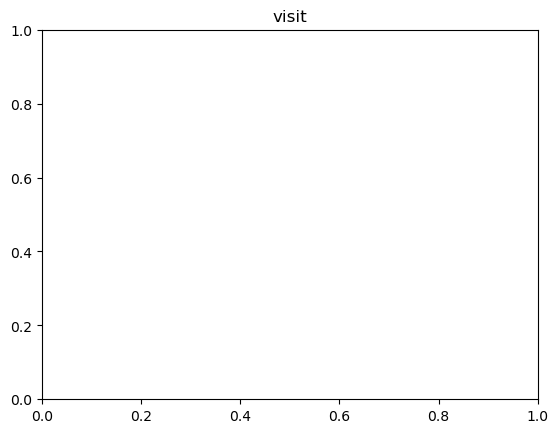

In [6]:
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(visit.image)
plt.title("visit")
plt.show()

## 2. Injecting Synthetic Sources

Now that we have retrieved a `visit_image`, we can inject our own synthetic sources into it. First, though, we need to set up a way to store all the necessary information regarding these sources.

The LSST Science Pipeline's `source_injection` package provides many tools to create synthetic sources. Namely, we'll be using the `generate_injection_catalog` function to create catalogs of sources to inject.

### 2.1. Define Parameters and Functions

Let's define some of the main parameters we will need for the source catalog generation and injection. 

First let's find the center of our chosen `visit_image` in ra,dec coordinates using the image's `wcs`, or "World Coordinate System". This will help us ensure the sources we inject are all within the image's bounds.

In [7]:
cen = visit.wcs.pixelToSky(visit.getBBox().getCenter())
cen_ra = cen.getRa().asDegrees()
cen_dec = cen.getDec().asDegrees()
print(cen)

(37.9749995622, +6.8602296478)


Additionally we'll obtain some basic information about the `visit_image`, including most importantly the image's WCS information, which will help us orient ourselves in the ra,dec coordinate system instead of the image's pixel coordinates.

In [8]:
psf = visit.getPsf()
photo_calib = visit.getPhotoCalib()
wcs = visit.getWcs()

### 2.2. Generate Injection Catalogs

Now let's actually generate the sources using the `generate_injection_catalog` method, for which we provide:
- `ra_lim`, `dec_lim`: The position bounds we want our sources to be generated within
- `number`: The number of repeats we desire for each source
- `seed`: A randomness seed 
- `mag`: A list of possible magnitudes for sources
- `source_type`: The kind of source we wish to inject.
    - We will primarily use the `"Star"`, `"Sersic"`(Galaxy), or `"Stamp"` options when injecting sources.
    - For the sake of this tutorial `"Sersic"` has been chosen for the easy visibility of injected galaxies compared to stars, which are considerably smaller and harder to visually notice being injected
- `n`,`q`,`beta`,`half_light_radius`: These are all parameters specific to the Sersic source type/Galsim model and pertain to the "Sersic index", minor-to-major axis ratio, rotation angle, and half-light radius, respectively.
    - For generating stars, we need only include the magnitude, none of the above. It is the same case for stamps, though with the additional requirement of a path to the .fits file containing the stamp data.

In [9]:
visit_injection_catalog = generate_injection_catalog(
    ra_lim=[ra-0.01, ra+0.01],
    dec_lim=[dec-0.01, dec+0.01],
    number=2,
    seed='432',
    mag=[15],
    source_type="Sersic",
    n=[2,4],
    q=[0.9],
    beta=[31.0, 144],
    half_light_radius=[5.0],
)

See that `visit_injection_catalog` is a table containing all the given information for each of the 8 sources we generated around the center of our image.

In [10]:
visit_injection_catalog

injection_id,ra,dec,mag,source_type,n,q,beta,half_light_radius
int64,float64,float64,int64,str6,int64,float64,float64,float64
0,37.92967058193254,6.932385839423772,15,Sersic,2,0.9,31.0,5.0
1,37.92467058193254,6.9257191727571055,15,Sersic,2,0.9,31.0,5.0
10,37.93717058193254,6.923496950534884,15,Sersic,2,0.9,144.0,5.0
11,37.93217058193254,6.934608061645994,15,Sersic,2,0.9,144.0,5.0
20,37.92717058193254,6.9368302838682165,15,Sersic,4,0.9,31.0,5.0
21,37.93467058193254,6.93016361720155,15,Sersic,4,0.9,31.0,5.0
30,37.93967058193254,6.939052506090438,15,Sersic,4,0.9,144.0,5.0
31,37.92217058193254,6.927941394979328,15,Sersic,4,0.9,144.0,5.0


### 2.3. Inject the Source Catalog

Finally, let's actually inject the sources we generated into our visit_image. To do that, first set up some simple configuration the LSST Science Pipeline requires that we'll need to perform the injection.

In [11]:
inject_config = VisitInjectConfig()
inject_task = VisitInjectTask(config=inject_config)

Now run the injection and inject `visit_injection_catalog` into a clone image of `visit`.

In [12]:
inj_visit = inject_task.run(
    injection_catalogs=visit_injection_catalog,
    input_exposure=visit.clone(),
    psf=psf,
    photo_calib=photo_calib,
    wcs=wcs,
)

Now display the injected `visit_image` on its own, then next to its original version using the `plot_save_two_images` method to clearly see the new injected galaxies. It's quite visible where our injections are clustered right in the middle!

waiting for ds9...

XPA$ERROR no 'xpaset' access points match template: ds9


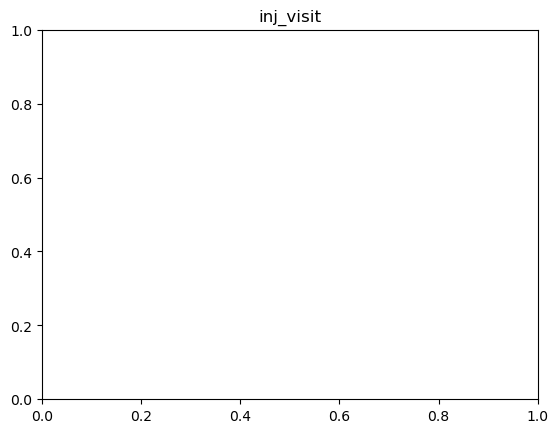

In [13]:
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(inj_visit.output_exposure.image)
plt.title("inj_visit")
plt.show()

In [14]:
plot_save_two_images(visit, inj_visit.output_exposure, "visit", "inj_visit")

NameError: name 'plot_save_two_images' is not defined

Look at all those sources! Congratulations, you've just made a whole bunch of injections into a real Rubin DP1 image.

## 3. Making Injections into Coadd Images

Unlike a `visit_image`, which is a single captured frame from the Vera C. Rubin Observatory's camera, a `coadd` image composites multiple exposures together through an "averaging" process to create a deeper, clearer image that can better eliminate noise in the observations.

### 3.1. Querying for Coadd Images using Butler

To gain more experience with using the Butler, we'll use a similar, though slightly different process to obtain and inject sources into Rubin data. First, let's start by querying for images from the DP1 data that satisfy the requirements outlined in our `query`, namely the band and ra,dec coordinates described earlier, as well as the type of coadd we wish to find, in this case the `deep_coadd` DP1 data product.

We use string formatting (_f"...{var1}..."_) to substitute our actual variable information into the fixed string that is already in the format required to query DP1 data with Butler.

As `coadd` images are compiled using data from many `visit_image`s, there will be fewer of them, hence our search only returning one result.

In [ ]:
query = f"band.name = '{band}' AND OVERLAPS POINT({ra}, {dec})"
coadd_data = butler.query_datasets("deep_coadd", where="band.name = band AND \
                                    patch.region OVERLAPS POINT(ra, dec)", 
                                    bind={"band": band, "ra": ra, "dec": dec})
print(len(coadd_data))

Now ask Butler to fetch the 0th(first) image it obtained in its search.

In [ ]:
coadd = butler.get(coadd_data[0])

Let's see what a `deep_coadd` image looks like! Run the below and notice how much clearer it appears compared to the `visit_image` we saw before, especially in how much more visible dim stars and galaxies are when against a less noisy background.

In [ ]:
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(coadd.image)
plt.title("coadd (deep_coadd)")
plt.show()

### 3.2. Injecting Source Catalogs into Coadd Images

Now let's finally inject our same `visit_injection_catalog` into our `deep_coadd` image. **Make sure to update the psf, photo_calib, and wcs to match the new image, otherwise the process will return an error.**

In [ ]:
psf = coadd.getPsf()
photo_calib = coadd.getPhotoCalib()
wcs = coadd.getWcs()

inj_coadd = inject_task.run(
    injection_catalogs=visit_injection_catalog,
    input_exposure=coadd.clone(),
    psf=psf,
    photo_calib=photo_calib,
    wcs=wcs,
)

Now let's see what the injected `deep_coadd` looks like. See that since we first queried for images around the center of this image, the injected sources appear right in the middle!

In [ ]:
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(inj_coadd.output_exposure.image)
plt.title("inj_coadd")
plt.show()

### 3.3. Comparing Injected Coadd and Visit Images

Let's see what the two injected images look like next to one another. It's easy to see that the `deep_coadd` image not only has much more detail and many more visible sources, but it also seems to be a bit more "zoomed in" than the `visit_image`. This is accurate, as in compiling many `visit_image` captures to form one image, the outermost edges of each image are lost and the resulting picture is a bit cropped.

In [ ]:
plot_save_two_images(inj_visit.output_exposure, inj_coadd.output_exposure, "inj_visit", "inj_coadd")

Though difficult to see from here directly as the sources appear slightly overexposed, you may also notice that the images appear to be rotated relative to one another, by about 180 degrees. The two galaxies close to one another in the top left corner of the cluster in the `visit_image` now appears in the bottom left of the `deep_coadd`. Why is this?

`visit_image` captures aren't specifically taken to align with any coordinate system in particular, including the ra,dec system, whereas `deep_coadd` images are intentionally rotated during composition to align to the ra,dec grid, with ra on the x-axis and dec on the y-axis.

Let's observe the rotation using some information provided by each `visit_image` in `visitInfo`, specifically using `visitInfo.boresightRotAngle`, which gives us the angle of the image relative to the positive dec(+y) axis.

In [ ]:
visit.visitInfo.boresightRotAngle

See that this angle is almost 180 degrees, and we know the `deep_coadd` to be already aligned to the ra,dec coordinate system (0 rotation). This explains the rotation we see between our `visit_image` and `coadd`!